# Exercise 3 - CNNs, ResNets and LR-Scheduling

## General information
* Deep Learning – Winter term 2020/21
* Instructor: Alexander Ecker
* Tutors: Max Burg, Laura Pede
* Teaching assistants: Clara Holzhüter, Pronaya Prosun Das
* Due date: **Tue, 15. Dec 20, 2:15pm**

### Time required to solve this exercise sheet
**As you will train a large number of models on this exercise sheet, model training will require an increased amount of time. So we recommend to start working on this sheet early.**

### Topics

In this exercise sheet, you will:
- work again with CIFAR-10
- implement a 1-layer CNN
- compare MLP and CNN
- vary architecture to improve model performance
- implement a ResNet for CIFAR-10
- learn about learning rate scheduling
- [learn about transfer learning]

*We are looking forward to seeing your solutions! Have fun!*

### Important submission instructions

- **You need to answer all questions in written form!**
- When you're done, download the notebook and rename it to \<surname1\>_\<surname2\>_\<surname3\>.ipynb
- Only submit the ipynb file, no other file is required
- Submit only once
- The deadline is strict
- You are required to present your solution in the tutorial; submission of the notebook alone is not sufficient
- Do not change the cells which are marked as "Do not change", similarly write your solution into the marked cells.

### Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('./drive/MyDrive/Deep_Learning_Lecture/Colab_Notebooks')
%ls

checkpoint_earlystopper.pt  Exercises1_2020.ipynb  model1        utils.py
data/                       Exercises2_2020.ipynb  private/
Exercise3_2020.ipynb        model/                 __pycache__/


## 1. Setup

You can use the functions to grab the data, split the sets and create the dataloaders, etc. given to you at exercise sheet 2.

It is good practice to store functions that are constantly needed again in a separate file such that instead of copy-pasting the cells into each exercise notebook, you can use the python file containing the functions and import it in the notebooks.

If you work with Colab (which is recommended) you have to mount the drive first and create a path to your python module.

#### **TODO**
Create a file named 'utils.py' and import it here. You can import any package necessary.

In [3]:
# TODO import utils.py
import utils

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, StepLR
import torchvision
from torchvision import datasets, transforms, models
import fastprogress
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import time

## 2. Load dataset, create dataloader, etc.

#### **TODO**
Call the functions of 'utils.py' to instantiate the train-, test- and validation datasets along with their dataloaders.

In [5]:
# TODO define device
device = utils.get_device()

cuda available: True ; cudnn available: True ; num devices: 1
Using device Tesla P4


In [6]:
data_dir = './data/'
batch_size = 256

# TODO grab data, generate split, init data loaders
trainset_raw, testset, dataset_mean, dataset_std = utils.grab_data(data_dir, num_cpus=2)
trainset, valset = utils.generate_train_val_data_split(trainset=trainset_raw, split_seed=1234, val_frac=0.2)
trainloader, valloader, testloader = utils.init_data_loaders(trainset=trainset, valset=valset, testset=testset, batch_size=batch_size, num_cpus=2)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [7]:
imgiter = iter(trainloader)
img_next, _ = imgiter.next()
img_next.shape

torch.Size([256, 3, 32, 32])

#### **TODO** 
Define the loss function. We use the cross entropy loss again.

In [8]:
# TODO define loss function
loss_fun  = nn.CrossEntropyLoss()

## 3. Simple 1-layer CNN model

### **TODO**
- Define the model.

The first step to training a model is defining its architecture. 
Define a sequential model with following structure:
*   Convolutional layer with 32 filters, kernel size of 5*5 and stride of 1.
*   Max Pooling layer with kernel size of 2*2 and default stride.
*   ReLU Activation Layers.
*   Linear layer with output of 512.
*   ReLU Activation Layers.
*   A linear layer with output of 10.

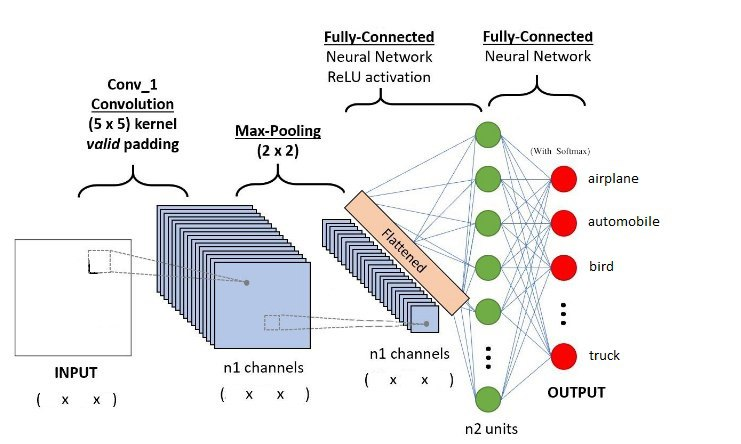

#### **Questions**

- What are the input dimensions?  **batch_size x 3 x (32 x 32)**
- What are the dimensions of the feature maps? **32 x (28 x 28)**
- What are the dimensions after pooling? **32 x (14 x 14), we use `stride=2` to reduce dimension!!!**
- What are the values for n1 and n2? **n1 = 32, n2 = 32 x 14 x 14** 
- What is the number of parameters for conv_1? **32 x 5 x 5 x 3** 

**Your answers here**

In [9]:
# TODO define model
class CNN1(nn.Module):
  def __init__(self, num_channels, num_classes):
    super(CNN1, self).__init__()
    self.conv1 = nn.Conv2d(num_channels, 32, 5) 
    self.pool1 = nn.MaxPool2d(2,2) 
    self.l1 = nn.Linear(32*14*14, 512)
    self.l2 = nn.Linear(512, num_classes)

  def forward (self, x):
    out = F.relu(self.pool1(self.conv1(x)))
    out = out.view(-1, 32*14*14)
    out = F.relu(self.l1(out))
    out = self.l2(out)
    return out

#### **TODO**

- Train the model for 10 epochs. Use a learning rate of 0.001.
- Plot the results of accuracy and loss as you did in exercise sheet 2.

Finished training after 109 seconds.


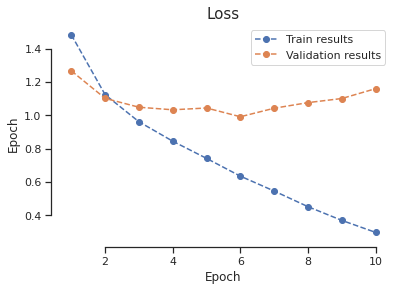

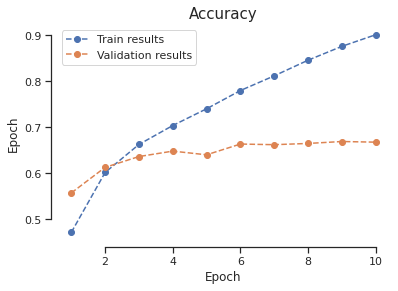

Training set: 
 minimum of loss: 	 0.30 	 at epoch: 	 10 
 maximum of accuracy: 	 0.90 	 at epoch: 	 10
Validation set: 
 minimum of loss: 	 0.99 	 at epoch: 	 6 
 maximum of accuracy: 	 0.67 	 at epoch: 	 9


In [ ]:
# TODO train and plot
num_epochs = 10
lr = 1e-3

model1 = CNN1(num_channels=3, num_classes=10).to(device)
optimizer = optim.Adam(model1.parameters(), lr=lr)

train_losses, val_losses, train_accs, val_accs, _ = utils.run_training(model=model1, optimizer=optimizer, loss_function=loss_fun, device=device, num_epochs=num_epochs,
                                                                 train_dataloader=trainloader, val_dataloader=valloader, verbose=True)

# visualization
utils.plot("Loss", "Epoch", train_losses, val_losses, yscale='linear')
utils.plot("Accuracy", "Epoch", train_accs, val_accs, yscale='linear')

utils.print_results(train_losses, train_accs, 'Training')
utils.print_results(val_losses, val_accs, 'Validation')

#### **TODO**
Compare results to MLP. What can you observe?

**We have achieved a much higher classification accuracy with fewer training epochs!**

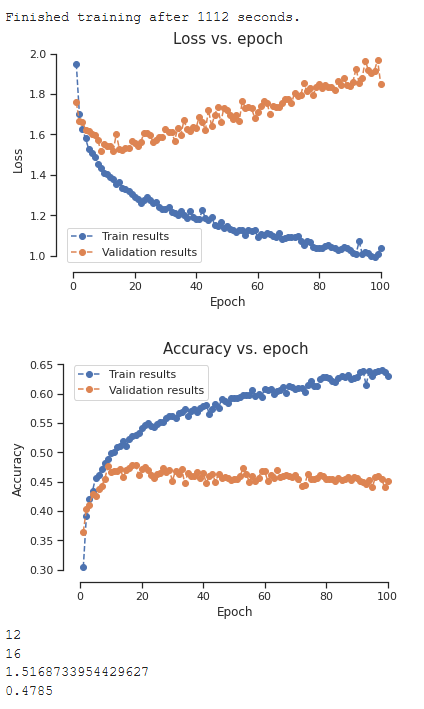

#### **TODO** 
Train longer (ca. 60 epochs), plot again.

Finished training after 675 seconds.


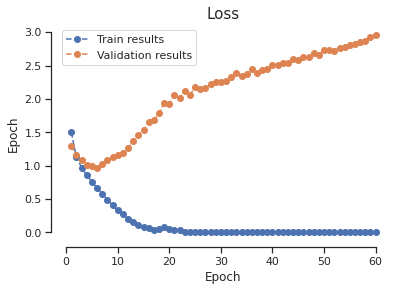

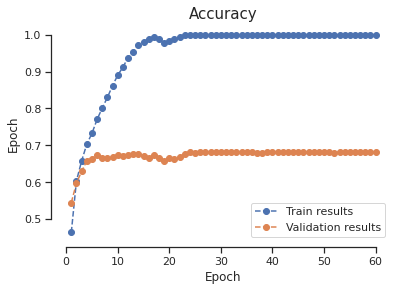

Training set: 
 minimum of loss: 	 0.00 	 at epoch: 	 60 
 maximum of accuracy: 	 1.00 	 at epoch: 	 26
Validation set: 
 minimum of loss: 	 0.97 	 at epoch: 	 6 
 maximum of accuracy: 	 0.68 	 at epoch: 	 42


In [ ]:
# TODO train and plot
num_epochs = 60
lr = 1e-3

model1 = CNN1(num_channels=3, num_classes=10).to(device)
optimizer = optim.Adam(model1.parameters(), lr=lr)

train_losses, val_losses, train_accs, val_accs, _ = utils.run_training(model=model1, optimizer=optimizer, loss_function=loss_fun, device=device, num_epochs=num_epochs,
                                                                 train_dataloader=trainloader, val_dataloader=valloader, verbose=False)

# visualization
utils.plot("Loss", "Epoch", train_losses, val_losses, yscale='linear')
utils.plot("Accuracy", "Epoch", train_accs, val_accs, yscale='linear')

utils.print_results(train_losses, train_accs, 'Training')
utils.print_results(val_losses, val_accs, 'Validation')

In [ ]:
model_dir = './model/'
utils.save_all(model_dir+'CNN1_60', model1, optimizer, num_epochs, {'train_losses': train_losses, 
                                                    'val_losses': val_losses, 
                                                    'train_accs': train_accs, 
                                                    'val_accs': val_accs})

In [10]:
# Check point:
lr = 1e-3
model1 = CNN1(num_channels=3, num_classes=10).to(device)
optimizer = optim.Adam(model1.parameters(), lr=lr)

model1, optimizer, num_epochs, other_stuffs = utils.load_all('./model/CNN1_60', model1, optimizer)

In [11]:
utils.print_results(other_stuffs['train_losses'], other_stuffs['train_accs'], 'Training')
utils.print_results(other_stuffs['val_losses'], other_stuffs['val_accs'], 'Validation')

Training set: 
 minimum of loss: 	 0.00 	 at epoch: 	 60 
 maximum of accuracy: 	 1.00 	 at epoch: 	 26
Validation set: 
 minimum of loss: 	 0.97 	 at epoch: 	 6 
 maximum of accuracy: 	 0.68 	 at epoch: 	 42


#### **Questions**
- Why is that not an optimal model?
- What could be improved?

**Because the loss for the validation set goes up from epoch 6 and we do not have a significant improvement of the classification accuracy through out the epochs** 

**Add more convolutional layers!!**

## 4. CNN model with more convolutional layers

#### **TODO**
Define the architecture displayed in the graphic.

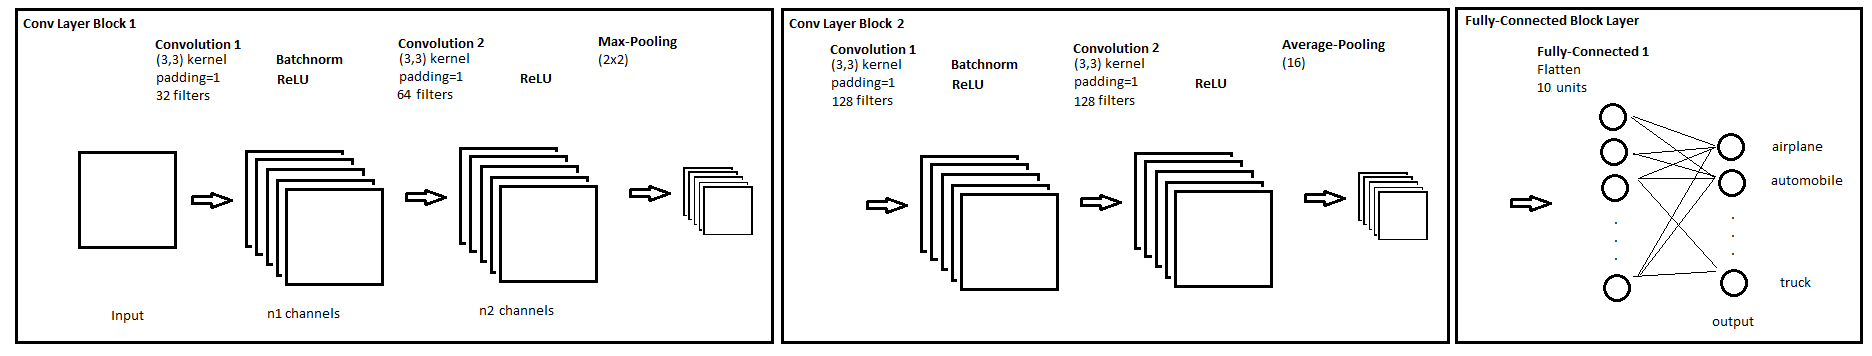

#### **Questions**

- Padding is used in the convolutional layers. What does that mean, which variants exist and how does it influence the dimensions of the feature maps?
- What does padding=1 mean in the case of the network displayed above?
- What are the dimensions of the feature maps after the 1. conv layer?
- What are the dimensions of the feature maps after the 2. conv layer?
- What ist the receptive field size after the first two convolutions?
- What is the value for the in_features for the fully-connected layer?
- What is the number of parameters of *Conv Layer block 1*?

**Your answers here**
- valid padding: dimensions of the feature maps shrinks by $k-1$ pxls, where $k$ is the kernel size; same padding: dimensions of the feature maps remains unchanged, i.e. $=$ input dimension
- It means adding 1 pxls at the edges in each directions (north east south west)
- **(32 x 32) x 32**
- **(32 x 32) x 64**
- **2+2+1=5**
- **1 x 1 x 128**
- **(3 x 3 x 32 x 3) + (3 x 3 x 64 x 32)**

In [30]:
#TODO define model 2
class CNN2(nn.Module):
  def __init__(self, num_channels, num_classes):
    super(CNN2, self).__init__()
    self.conv1_1  = nn.Conv2d(num_channels, 32, 3, padding=1)
    self.bnorm1   = nn.BatchNorm2d(32)
    self.conv1_2  = nn.Conv2d(32, 64, 3, padding=1) 
    self.pool1    = nn.MaxPool2d(2,2)
    self.conv2_1  = nn.Conv2d(64, 128, 3, padding=1)
    self.bnorm2   = nn.BatchNorm2d(128)
    self.conv2_2  = nn.Conv2d(128, 128, 3, padding=1) 
    self.pool2    = nn.AvgPool2d(16)
    self.l1       = nn.Linear(128, num_classes)

  def forward (self, x):
    out = self.bnorm1(F.relu(self.conv1_1(x)))
    out = self.pool1(F.relu(self.conv1_2(out)))
    out = self.bnorm2(F.relu(self.conv2_1(out)))
    out = self.pool2(F.relu(self.conv2_2(out)))
    out = out.view(-1, 128)
    out = self.l1(out)
    return out

#### **TODO** 

- train the new net (30 epochs, lr=0.1), plot the results, and compare the results to the 1-layer CNN
- explain why you observe these results

Finished training after 416 seconds.


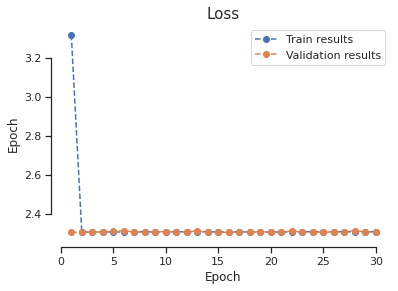

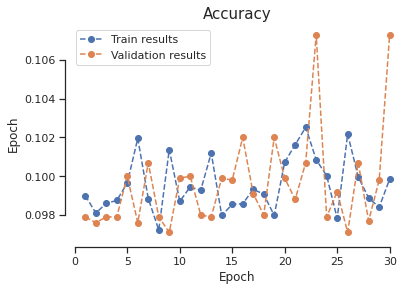

Training set: 
 minimum of loss: 	 2.31 	 at epoch: 	 2 
 maximum of accuracy: 	 0.10 	 at epoch: 	 22
Validation set: 
 minimum of loss: 	 2.30 	 at epoch: 	 16 
 maximum of accuracy: 	 0.11 	 at epoch: 	 23


In [31]:
# TODO train and plot
num_epochs = 30
lr = 1e-1

model2 = CNN2(num_channels=3, num_classes=10).to(device)
optimizer = optim.Adam(model2.parameters(), lr=lr)

train_losses, val_losses, train_accs, val_accs, _ = utils.run_training(model=model2, optimizer=optimizer, loss_function=loss_fun, device=device, num_epochs=num_epochs,
                                                                 train_dataloader=trainloader, val_dataloader=valloader, verbose=False)

# visualization
utils.plot("Loss", "Epoch", train_losses, val_losses, yscale='linear')
utils.plot("Accuracy", "Epoch", train_accs, val_accs, yscale='linear')

utils.print_results(train_losses, train_accs, 'Training')
utils.print_results(val_losses, val_accs, 'Validation')

Finished training after 420 seconds.


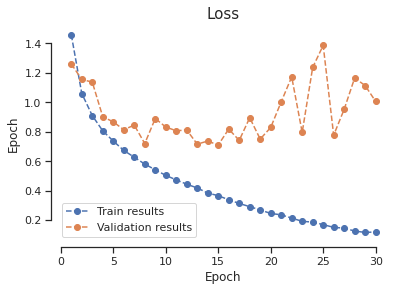

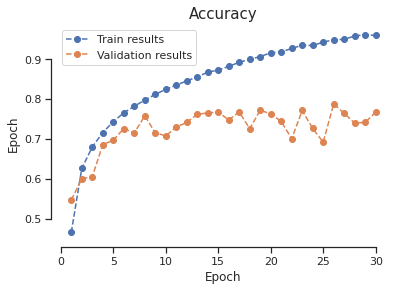

Training set: 
 minimum of loss: 	 0.12 	 at epoch: 	 29 
 maximum of accuracy: 	 0.96 	 at epoch: 	 29
Validation set: 
 minimum of loss: 	 0.71 	 at epoch: 	 15 
 maximum of accuracy: 	 0.79 	 at epoch: 	 26


In [32]:
# TODO train and plot
num_epochs = 30
lr = 1e-3

model2 = CNN2(num_channels=3, num_classes=10).to(device)
optimizer = optim.Adam(model2.parameters(), lr=lr)

train_losses, val_losses, train_accs, val_accs, _ = utils.run_training(model=model2, optimizer=optimizer, loss_function=loss_fun, device=device, num_epochs=num_epochs,
                                                                 train_dataloader=trainloader, val_dataloader=valloader, verbose=False)

# visualization
utils.plot("Loss", "Epoch", train_losses, val_losses, yscale='linear')
utils.plot("Accuracy", "Epoch", train_accs, val_accs, yscale='linear')

utils.print_results(train_losses, train_accs, 'Training')
utils.print_results(val_losses, val_accs, 'Validation')

In [33]:
model_dir = './model/'
utils.save_all(model_dir+'CNN2_30', model2, optimizer, num_epochs, {'train_losses': train_losses, 
                                                    'val_losses': val_losses, 
                                                    'train_accs': train_accs, 
                                                    'val_accs': val_accs})

In [34]:
# Check point:
lr = 1e-3
model2 = CNN2(num_channels=3, num_classes=10).to(device)
optimizer = optim.Adam(model2.parameters(), lr=lr)

model2, optimizer, num_epochs, other_stuffs = utils.load_all('./model/CNN2_30', model2, optimizer)

utils.print_results(other_stuffs['train_losses'], other_stuffs['train_accs'], 'Training')
utils.print_results(other_stuffs['val_losses'], other_stuffs['val_accs'], 'Validation')

Training set: 
 minimum of loss: 	 0.12 	 at epoch: 	 29 
 maximum of accuracy: 	 0.96 	 at epoch: 	 29
Validation set: 
 minimum of loss: 	 0.71 	 at epoch: 	 15 
 maximum of accuracy: 	 0.79 	 at epoch: 	 26


## 5. ResNet architecture

"*Deeper neural networks are more difficult to train.  We present a residual learning framework to ease the training of networks that are substantially deeper than those used previously.*" [ https://arxiv.org/pdf/1512.03385.pdf]

That was the intention of He et al. to develop residual networks.

A ResNet is built of blocks which are called the *Residual Blocks*. 
A residual block uses *skip connections* - shortCuts — to jump over some layers to skip some activations.
The Resnet skips connections via addition.

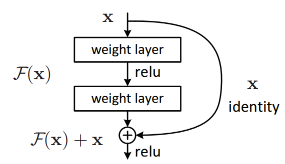

#### **Questions**
- Which problems do using skip connections solve?
- Why is a residual network called residual? 
- When is the advantage of ResNets over 'normal' CNNs most visible?

**Your answers here**

#### **TODO**
- write a class **ResidualBlock(nn.Module)** where you define the blocks used in the ResNet
- write a class **ResNet(nn.Module)** where you define the model; the class contains the following methods:
    - init
    - make_layer
    - forward
- train the model
- plot results

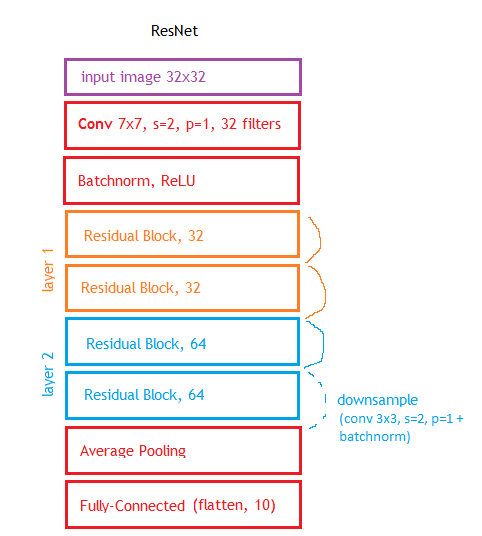
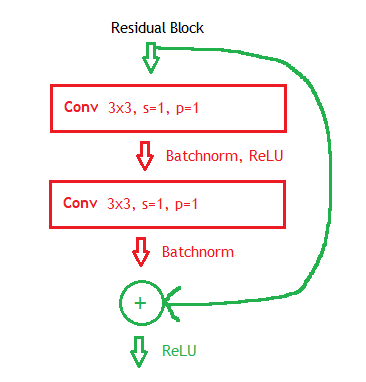

In [ ]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

class ResidualBlock(nn.Module):
    '''
        Conv--> Batchnorm-->ReLu-->Conv-->Batchnorm--> 
        Only downsample if needed
    '''
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        # TODO
        
        
    def forward(self, x):
        # TODO

        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        # TODO

        
    def make_layer(self, block, out_channels, blocks, stride=1, padding=0):
        # TODO

    
    def forward(self, x):
        # TODO
        
        return out

In [ ]:
# TODO train and plot

#### **Questions**
- Does the performance increase compared to the CNNs you trained before? Why/Why not?
- Compare the runtime of CNN and ResNet.

**Your answers here**

## 6. Explore Learning Rate Scheduling

Learning rate scheduling is a mechanism to adjust the learning rate.

*torch.optim.lr_scheduler* provides several methods based on the number of epochs. Learning rate scheduling should be applied after optimizer’s update.

#### **TODO**
- change run_training and extend to use scheduler for learning rate
- use StepLR (https://pytorch.org/docs/stable/optim.html), use the ResNet, train for 10 epochs. Start with a learning rate of 0.1.


#### **Questions**

- Try step size 1, gamma 0.1
    - How does it change the learning rate?
    - what do you observe regarding performance?
- Try step size 1, gamma 0.9, what do you observe?
    - How does it change the learning rate?
    - what do you observe regarding performance?
- What can you conclude of this experiment regarding the synergy of step size and gamma to get a good schedule?

**Your answers here**

In [ ]:
# TODO change run_training (you can copy the code from utils.py here and create a new method here 
# or just change/create a new method it in the python file)

In [ ]:
# TODO train and plot with step size 1, gamma 0.1

In [ ]:
# TODO train and plot with step size 1, gamma 0.9

#### **TODO** 

Use the learning rate schedule as described in the ResNet paper (https://arxiv.org/pdf/1512.03385.pdf). Train for 30 epochs.

#### **Questions**
- Does it improve performance?
- What can you observe in the plots?

**Your answers here**

In [ ]:
# TODO train and plot with scheduling, optimizer, lr as in the paper.

## [7. Optional LR-Scheduling]

#### **TODO**
- try two more scheduler: ExponentialLR and ReduceLROnPlateau 
- vary the parameters, which work best?
- does it improve performance compared to no scheduler?
- does it improve performance compared to StepLR?

**Your answers here**

In [ ]:
# TODO train and plot

## [8. Optional Transfer Learning]

### **TODO**

- load a pretrained ResNet from torchvision
- freeze the parameters so that the gradients are not computed
- replace the last fully-connected layer
- fine-tune the model
- plot the results again and compare to approaches before
    - is a better performance reached? why/why not?
    - does it take more/less time to fine-tune compared to train a resnet?

**Your answers here**

In [ ]:
# TODO do transfer learning with resnet on cifar10